In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import interpolate
from IPython.display import Video
from IPython.display import Audio
from scipy.io.wavfile import write

In [3]:
def get_interpolated(array, index):
    if not hasattr(array, "__len__"): return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [10]:
get_interpolated(np.array([[0, 1, 2], [10, 20, 30]]), (0.9, 0.1))

9.91

In [17]:
def calculate_next_psi(psi, dt, potential):
    n = psi.shape[0]
    next_psi = np.zeros((n, n), dtype=np.complex_)
    
    # potential-part
    next_psi = [[psi[i, j] * np.exp(1j * dt * potential[i, j]) for j in range(n)] for i in range(n)]

    next_psi = np.fft.fft2(next_psi)
    
    for i in range(n):
        for j in range(n):
            k = 2*np.pi * min(i, n-i)
            l = 2*np.pi * min(j, n-j)
            theta = (k*k + l*l) * dt
            next_psi[i, j] *= np.exp(1j * theta)
    
    next_psi = np.fft.ifft2(next_psi)
    return next_psi

In [18]:
def gaussian(x, y, n, offset, width):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return np.exp(-(x*x + y*y) / (width*width)) + 0j

In [19]:
def parabolar(x, y, n, offset, factor):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return factor * (x*x + y*y)
    

In [20]:
parabolar(64, 0, 128, [0, 0], 1)

1.0

In [21]:
def circle(rad, radius, offset, n):
    return (radius * np.array([np.cos(rad), np.sin(rad)]) + offset) * n//2 + n//2

In [22]:
np.concatenate(([5], circle(0, 1, 0, 128)), axis=0)

array([  5., 128.,  64.])

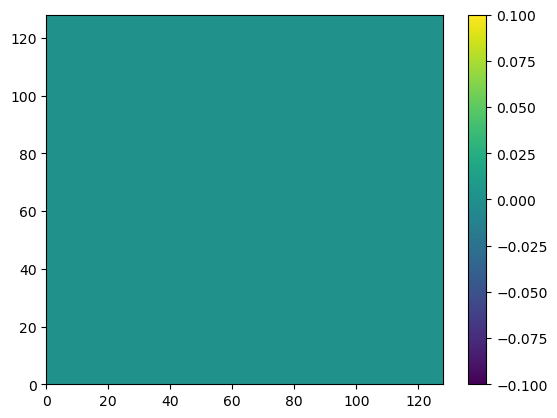

Finished simulation


In [23]:
n = 128
fps = 12
duration = 5

samplerate = 44100
frequency = 110
interest_radius = 0.5
interest_center = [0, 0]

frames = [] # for storing the generated images

psi = np.array([[gaussian(x, y, n, offset=[-0.5, 0.0], width=0.15) for x in range(n)] for y in range(n)])
potential = np.array([[parabolar(x, y, n, offset=[0,0], factor=0) for x in range(n)] for y in range(n)])
frames.append(psi)

#plt.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
plt.pcolormesh(potential)
plt.colorbar()
plt.show()


for i in range(fps*duration):
    for timestep in range(1):
        psi = calculate_next_psi(psi, 0.005 / fps, potential)
    frames.append(psi)

print("Finished simulation")


In [25]:
# Sonification
rad_per_sample = 2 * np.pi * frequency / samplerate
audio = [np.square(np.abs(get_interpolated(frames, np.concatenate((np.array([i * fps/samplerate]), circle(rad_per_sample * i, interest_radius, interest_center, n)), axis=0)))) for i in range(samplerate*duration)]

print("Finished sonicifaction")

Finished sonicifaction


In [28]:
%rm test.mp4

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('test.mp4', fourcc, fps, (800, 600))
for i in range(len(frames)):
    plt.figure(figsize=(8, 6))
    plot = plt.pcolormesh(pow(np.abs(frames[i]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1, animated=True)
    plt.colorbar()
    plt.title('psi')

    # Save to temporary file
    plt.savefig('temp_frame.png')
    plt.close()

    # Read the image and add to the video
    img = cv2.imread('temp_frame.png')
    video.write(img)

video.release()

rm: test.mp4: No such file or directory


Exception ignored in: <function Wave_write.__del__ at 0x7fc7d9e50af0>
Traceback (most recent call last):
  File "/Users/jannismuller/anaconda3/envs/qsynthi_prototypes/lib/python3.8/wave.py", line 327, in __del__
    self.close()
  File "/Users/jannismuller/anaconda3/envs/qsynthi_prototypes/lib/python3.8/wave.py", line 445, in close
    self._ensure_header_written(0)
  File "/Users/jannismuller/anaconda3/envs/qsynthi_prototypes/lib/python3.8/wave.py", line 468, in _ensure_header_written
    self._write_header(datasize)
  File "/Users/jannismuller/anaconda3/envs/qsynthi_prototypes/lib/python3.8/wave.py", line 472, in _write_header
    self._file.write(b'RIFF')
ValueError: I/O operation on closed file.


In [27]:
Audio(audio, rate=samplerate)